In [4]:
import torch
import gym
import math
import random
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
from collections import namedtuple, deque
from itertools import count

In [15]:
class DQN(torch.nn.Module):
    def __init__(self, n_observations, n_actions, dropout_rate=0.5):
        super(DQN, self).__init__()
        self.layer1 = torch.nn.Linear(n_observations, 128)
        self.layer2 = torch.nn.Linear(128, 128)
        self.layer3 = torch.nn.Linear(128, n_actions)

    def forward(self, x):
        x = torch.nn.functional.relu(self.layer1(x))
        x = torch.nn.functional.relu(self.layer2(x))
        return self.layer3(x)

In [16]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
        self.transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

    def push(self, *args):
        self.memory.append(self.transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [19]:
class DQNAgent:
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.env = gym.make("CartPole-v1")
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n

        self.episodes = 600
        self.episode_durations = []
        self.steps_done = 0

        self.batch_size = 128  # number of transitions sampled from the replay buffer
        self.gamma = 0.99  # discount factor
        self.epsilon_start = 0.9  # starting value of epsilon
        self.epsilon_end = 0.05  # final value of epsilon
        self.epsilon_decay = 1000  # rate of exponential decay of epsilon (higher -> slower decay
        self.tau = 0.005  # update rate of the target network
        self.lr = 1e-4  # learning rate of the ``AdamW`` optimizer

        self.policy_net = DQN(self.state_size, self.action_size).to(self.device)
        self.target_net = DQN(self.state_size, self.action_size).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = torch.optim.AdamW(self.policy_net.parameters(), lr=self.lr, amsgrad=True)
        self.memory = ReplayMemory(10000)

    def plot_durations(self, show_result=False):
        plt.figure(1)
        durations_t = torch.tensor(self.episode_durations, dtype=torch.float)
        if show_result:
            plt.title('Result')
        else:
            plt.clf()
            plt.title('Training...')
        plt.xlabel('Episode')
        plt.ylabel('Duration')
        plt.plot(durations_t.numpy())

        # Take 100 episode averages and plot them too
        if len(durations_t) >= 100:
            means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(99), means))
            plt.plot(means.numpy())

        plt.pause(0.001)  # pause a bit so that plots are updated
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

    def act(self, state):
        sample = random.random()
        eps_threshold = self.epsilon_end  + (self.epsilon_start - self.epsilon_end) * \
            math.exp(-1. * self.steps_done / self.epsilon_decay)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                # t.max(1) will return the largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                return self.policy_net(state).max(1).indices.view(1, 1)
        else:
            return torch.tensor([[self.env.action_space.sample()]], device=self.device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return
        transitions = self.memory.sample(self.batch_size)

        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = self.memory.transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=self.device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1).values
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(self.batch_size, device=self.device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1).values

        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch

        # Compute Huber loss
        criterion = torch.nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()

        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()

    def load(self, name):
        self.policy_net.load_state_dict(torch.load(name))
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def save(self, name):
        torch.save(self.policy_net.state_dict(), name)

    def train(self):
        for _ in range(self.episodes):
            # Initialize the environment and get its state
            state = self.env.reset()
            state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            for t in count():
                action = self.act(state)
                observation, reward, done, _ = self.env.step(action.item())
                reward = torch.tensor([reward], device=self.device)

                if done:
                    next_state = None
                else:
                    next_state = torch.tensor(observation, dtype=torch.float32, device=self.device).unsqueeze(0)

                # Store the transition in memory
                self.memory.push(state, action, next_state, reward)

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                self.optimize_model()

                # Soft update of the target network's weights
                # θ′ ← τ θ + (1 −τ )θ′
                target_net_state_dict = self.target_net.state_dict()
                policy_net_state_dict = self.policy_net.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key]*self.tau + target_net_state_dict[key]*(1-self.tau)
                self.target_net.load_state_dict(target_net_state_dict)

                if done:
                    self.episode_durations.append(t + 1)
                    self.plot_durations()
                    break

    def test(self, episodes=10):
        self.policy_net.eval()
        for e in range(episodes):
            state = self.env.reset()
            state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            done = False
            total_reward = 0

            while not done:
                with torch.no_grad():
                    action = self.policy_net(state).max(1).indices.view(1, 1)

                observation, reward, done, _ = self.env.step(action.item())
                total_reward += reward

                if done:
                    print(f"Episode: {e+1}/{episodes}, Score: {total_reward}")
                    break

                state = torch.tensor(observation, dtype=torch.float32,
                                device=self.device).unsqueeze(0)



In [20]:
agent = DQNAgent()
agent.train()
agent.save("dqn_cartpole.pth")
agent.load("dqn_cartpole.pth")
agent.test()

<ipython-input-19-958664ef73b0>:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.policy_net.load_state_dict(torch.load(name))


Episode: 1/10, Score: 149.0
Episode: 2/10, Score: 151.0
Episode: 3/10, Score: 166.0
Episode: 4/10, Score: 179.0
Episode: 5/10, Score: 142.0
Episode: 6/10, Score: 147.0
Episode: 7/10, Score: 143.0
Episode: 8/10, Score: 163.0
Episode: 9/10, Score: 143.0
Episode: 10/10, Score: 168.0


Complete


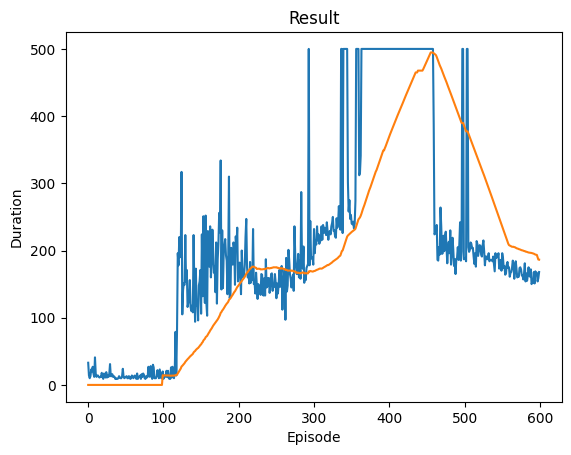

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [21]:
print('Complete')
agent.plot_durations(show_result=True)
plt.ioff()
plt.show()